https://www.tensorflow.org/tutorials/structured_data/time_series

In [39]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

# mpl.rcParams['figure.figsize'] = (8, 6)
# mpl.rcParams['axes.grid'] = False

## Functions

In [40]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []
    
    start_index = start_index + history_size
    
    print(start_index, end_index)
    
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    
    return np.array(data), np.array(labels)

In [41]:
def create_time_steps(length):
    return list(range(-length, 0))

## Data

In [42]:
from load_data import load_data
df = load_data('2020-04-01_draw_results')

11


In [43]:
df.tail(4)

,Draw,Date,1,2,3,4,5,6,Bonus,Bonus 2nd,Powerball
1943,1944,2020-03-21,9,18,16,20,28,19,7,NaN,5.0
1944,1945,2020-03-25,17,8,27,7,10,21,29,NaN,7.0
1945,1946,2020-03-28,3,2,39,19,35,37,23,NaN,10.0
1946,1947,2020-04-01,8,21,25,28,32,35,18,0.0,3.0


In [44]:
sort_balls = True

if sort_balls: 
    df[['1','2','3','4','5','6']]=df[['1','2','3','4','5','6']].apply(np.sort,axis=1, raw=True, result_type='broadcast')
df.tail(4)

,Draw,Date,1,2,3,4,5,6,Bonus,Bonus 2nd,Powerball
1943,1944,2020-03-21,9,16,18,19,20,28,7,NaN,5.0
1944,1945,2020-03-25,7,8,10,17,21,27,29,NaN,7.0
1945,1946,2020-03-28,2,3,19,35,37,39,23,NaN,10.0
1946,1947,2020-04-01,8,21,25,28,32,35,18,0.0,3.0


In [45]:
# Drops the last Draw resul for test only
# df.loc[df['Draw'] == 1947]

df = df[df['Draw'] != 1947]
df.tail(2)

,Draw,Date,1,2,3,4,5,6,Bonus,Bonus 2nd,Powerball
1944,1945,2020-03-25,7,8,10,17,21,27,29,NaN,7.0
1945,1946,2020-03-28,2,3,19,35,37,39,23,NaN,10.0


## Ball to Predict

In [46]:
univariate = True

For univariate 

In [48]:
# Ball_to_predict = '1'
# Ball_to_predict = '2'
# Ball_to_predict = '3'
# Ball_to_predict = '4'
# Ball_to_predict = '5'
# Ball_to_predict = '6'
Ball_to_predict = 'Bonus'
#Ball_to_predict = 'Bonus 2nd'
# Ball_to_predict = 'Powerball'

For Multi-variate

In [49]:
features_considered = [ '1', '2', '3', '4', '5', '6']

In [50]:
if univariate == True:
    features_considered = [Ball_to_predict]
    
features_considered = features_considered

In [51]:
# dft = df[['Date']+features_considered]
dft = df[features_considered]

In [52]:
for i in features_considered:
    dft = dft.dropna(subset=[i])
    dft = dft[dft[i] != 0]
dft

,Bonus
0,30
1,38
2,38
3,14
4,15
...,...
1941,37
1942,32
1943,7
1944,29


In [53]:
uni_data = dft
# uni_data.index = dft['Date']
print(uni_data.index)
uni_data.tail()

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945],
           dtype='int64', length=1946)


,Bonus
1941,37
1942,32
1943,7
1944,29
1945,23


array([<matplotlib.axes._subplots.AxesSubplot object at 0x14a0fa6d0>],
      dtype=object)

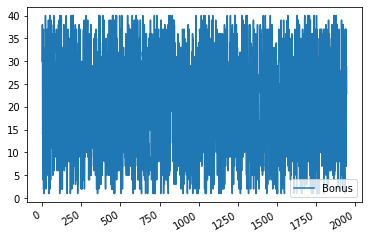

In [54]:
uni_data.plot(subplots=True)

In [55]:
uni_data = uni_data.values

In [56]:
TRAIN_SPLIT = int(len(dft.index)*.8)
#TRAIN_SPLIT = int(dft['Draw'].loc[df['Draw'].idxmax()]*.8)
print( len(dft.index*.7),TRAIN_SPLIT)

1946 1556


In [57]:
tf.random.set_seed(13)

In [58]:
print('Min:',uni_data[:TRAIN_SPLIT].min(),'\nMax:',uni_data[:TRAIN_SPLIT].max())

Min: 1 
Max: 40


In [59]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_mean

20.226221079691516

In [60]:
uni_train_std = uni_data[:TRAIN_SPLIT].std()
uni_train_std

11.581286712413869

In [61]:
print('Min:',uni_data[:TRAIN_SPLIT].min(),'\nMax:',uni_data[:TRAIN_SPLIT].max())

Min: 1 
Max: 40


In [62]:
uni_data = (uni_data - uni_train_mean) / uni_train_std
uni_data

array([[ 0.84392859],
       [ 1.53469812],
       [ 1.53469812],
       ...,
       [-1.14203382],
       [ 0.75758239],
       [ 0.23950525]])

In [63]:
univariate_past_history = 8
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)

8 1556


In [64]:
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

1564 None


In [65]:
print(x_train_uni.shape, y_train_uni.shape)

(1548, 8, 1) (1548, 1)


In [66]:
print(x_val_uni.shape, y_val_uni.shape)

(382, 8, 1) (382, 1)


In [67]:
BATCH_SIZE = 256
BUFFER_SIZE = 300

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [68]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [69]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


In [70]:
EVALUATION_INTERVAL = 300
EPOCHS = 100

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Train for 300 steps, validate for 50 steps
Epoch 1/100
300/300 [==============================] - 3s 9ms/step - loss: 0.8567 - val_loss: 0.8809
Epoch 2/100
300/300 [==============================] - 1s 5ms/step - loss: 0.8571 - val_loss: 0.8834
Epoch 3/100
300/300 [==============================] - 1s 4ms/step - loss: 0.8539 - val_loss: 0.8838
Epoch 4/100
300/300 [==============================] - 1s 5ms/step - loss: 0.8607 - val_loss: 0.8867
Epoch 5/100
300/300 [==============================] - 1s 5ms/step - loss: 0.8553 - val_loss: 0.8897
Epoch 6/100
300/300 [==============================] - 1s 4ms/step - loss: 0.8582 - val_loss: 0.8949
Epoch 7/100
300/300 [==============================] - 1s 4ms/step - loss: 0.8561 - val_loss: 0.8995
Epoch 8/100
300/300 [==============================] - 1s 4ms/step - loss: 0.8637 - val_loss: 0.8968
Epoch 9/100
300/300 [==============================] - 1s 4ms/step - loss: 0.8560 - val_loss: 0.8989
Epoch 10/100
300/300 [==========================

Epoch 81/100
300/300 [==============================] - 1s 4ms/step - loss: 0.7630 - val_loss: 0.9487
Epoch 82/100
300/300 [==============================] - 1s 4ms/step - loss: 0.7626 - val_loss: 0.9494
Epoch 83/100
300/300 [==============================] - 1s 4ms/step - loss: 0.7621 - val_loss: 0.9484
Epoch 84/100
300/300 [==============================] - 1s 4ms/step - loss: 0.7572 - val_loss: 0.9567
Epoch 85/100
300/300 [==============================] - 1s 4ms/step - loss: 0.7578 - val_loss: 0.9595
Epoch 86/100
300/300 [==============================] - 1s 4ms/step - loss: 0.7473 - val_loss: 0.9543
Epoch 87/100
300/300 [==============================] - 1s 4ms/step - loss: 0.7556 - val_loss: 0.9555
Epoch 88/100
300/300 [==============================] - 1s 4ms/step - loss: 0.7536 - val_loss: 0.9570
Epoch 89/100
300/300 [==============================] - 1s 4ms/step - loss: 0.7502 - val_loss: 0.9564
Epoch 90/100
300/300 [==============================] - 1s 4ms/step - loss: 0.7461

In [71]:
score = simple_lstm_model.evaluate(x_val_uni, y_val_uni, verbose=1)
score

382/382 [==============================] - 0s 703us/sample - loss: 0.9693


0.9693371896968462

In [72]:
ver = '003'
simple_lstm_model.save('./Models/' + Ball_to_predict + ver)

INFO:tensorflow:Assets written to: ./Models/Bonus003/assets


# Predict

In [73]:
last_result = np.reshape(
    np.array(dft[Ball_to_predict].tail(8)),
    (8,1))
last_result.shape

(8, 1)

In [74]:
last_result

array([[ 7],
       [12],
       [37],
       [37],
       [32],
       [ 7],
       [29],
       [23]])

In [75]:
last_result = ((last_result-uni_train_mean)/uni_train_std)
last_result

array([[-1.14203382],
       [-0.71030286],
       [ 1.44835193],
       [ 1.44835193],
       [ 1.01662097],
       [-1.14203382],
       [ 0.75758239],
       [ 0.23950525]])

In [76]:
last_result = tf.convert_to_tensor(
    [last_result,last_result], dtype=np.float64, dtype_hint=None, name=None)
last_result

<tf.Tensor: shape=(2, 8, 1), dtype=float64, numpy=
array([[[-1.14203382],
        [-0.71030286],
        [ 1.44835193],
        [ 1.44835193],
        [ 1.01662097],
        [-1.14203382],
        [ 0.75758239],
        [ 0.23950525]],

       [[-1.14203382],
        [-0.71030286],
        [ 1.44835193],
        [ 1.44835193],
        [ 1.01662097],
        [-1.14203382],
        [ 0.75758239],
        [ 0.23950525]]])>

# Predict current draw

In [77]:
simple_lstm_model.predict(last_result[:1]) * uni_train_std + uni_train_mean

array([[19.898205]], dtype=float32)

In [78]:
Ball_to_predict = ['1','2','3']
for i in Ball_to_predict:
    print(df[i])

0       4
1       3
2       5
3       2
4       3
       ..
1941    9
1942    2
1943    9
1944    7
1945    2
Name: 1, Length: 1946, dtype: int64
0        8
1        9
2       11
3        4
4        7
        ..
1941    13
1942    12
1943    16
1944     8
1945     3
Name: 2, Length: 1946, dtype: int64
0       16
1       13
2       18
3       10
4        8
        ..
1941    22
1942    18
1943    18
1944    10
1945    19
Name: 3, Length: 1946, dtype: int64


In [79]:
import datetime

In [81]:
datetime.datetime.today()

datetime.datetime(2020, 4, 3, 19, 50, 37, 970339)